
# Handwritten digits recognition using SKLearn MLP and HoG features 



In [ ]:

# Import required packages:
import cv2
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Constants:
SIZE_IMAGE = 20
NUMBER_CLASSES = 10


In [2]:
def load_digits_and_labels(big_image):
    """ Returns all the digits from the 'big' image and creates the corresponding labels for each image"""

    # Load the 'big' image containing all the digits:
    digits_img = cv2.imread(big_image, 0)

    # Get all the digit images from the 'big' image:
    number_rows = digits_img.shape[1] / SIZE_IMAGE
    rows = np.vsplit(digits_img, digits_img.shape[0] / SIZE_IMAGE)

    digits = []
    for row in rows:
        row_cells = np.hsplit(row, number_rows)
        for digit in row_cells:
            digits.append(digit)
    digits = np.array(digits)

    # Create the labels for each image:
    labels = np.repeat(np.arange(NUMBER_CLASSES), len(digits) / NUMBER_CLASSES)
    return digits, labels

In [3]:
def deskew(img):
    """Pre-processing of the images"""

    m = cv2.moments(img)
    if abs(m['mu02']) < 1e-2:
        return img.copy()
    skew = m['mu11'] / m['mu02']
    M = np.float32([[1, skew, -0.5 * SIZE_IMAGE * skew], [0, 1, 0]])
    img = cv2.warpAffine(img, M, (SIZE_IMAGE, SIZE_IMAGE), flags=cv2.WARP_INVERSE_MAP | cv2.INTER_LINEAR)
    return img

In [4]:
def get_hog():
    """Get hog descriptor"""

    # cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins, derivAperture, winSigma, histogramNormType,
    # L2HysThreshold, gammaCorrection, nlevels, signedGradient)
    hog = cv2.HOGDescriptor((SIZE_IMAGE, SIZE_IMAGE), (8, 8), (4, 4), (8, 8), 9, 1, -1, 0, 0.2, 1, 64, True)

    print("get descriptor size: {}".format(hog.getDescriptorSize()))

    return hog


In [5]:
def raw_pixels(img):
    """Return raw pixels as feature from the image"""

    return img.flatten()


In [6]:
# Load all the digits and the corresponding labels:
digits, labels = load_digits_and_labels('digits.png')

# Shuffle data
# Constructs a random number generator:
rand = np.random.RandomState(1234)
# Randomly permute the sequence:
shuffle = rand.permutation(len(digits))
digits, labels = digits[shuffle], labels[shuffle]

In [7]:
# HoG feature descriptor:
hog = get_hog()

# Compute the descriptors for all the images.
# In this case, the HoG descriptor is calculated
hog_descriptors = []
for img in digits:
    hog_descriptors.append(hog.compute(deskew(img)))
hog_descriptors = np.squeeze(hog_descriptors)

get descriptor size: 144


In [8]:
# At this point we split the data into training and testing (70% for training):
hog_descriptors_train, hog_descriptors_test, labels_train, labels_test = train_test_split(hog_descriptors,labels,random_state=1, test_size=0.3)

In [9]:
print('Training MLP model ...')

clf = MLPClassifier(hidden_layer_sizes=(256,128,64,32),activation="relu",random_state=25)
clf.fit(hog_descriptors_train, labels_train)

Training MLP model ...


MLPClassifier(hidden_layer_sizes=(256, 128, 64, 32), random_state=25)

In [10]:
print('Evaluating model ... ')

#y_pred=clf.predict(X_testscaled)
print(clf.score(hog_descriptors_test, labels_test))


#svm_evaluate(model, hog_descriptors_test, labels_test)

Evaluating model ... 
0.9813333333333333


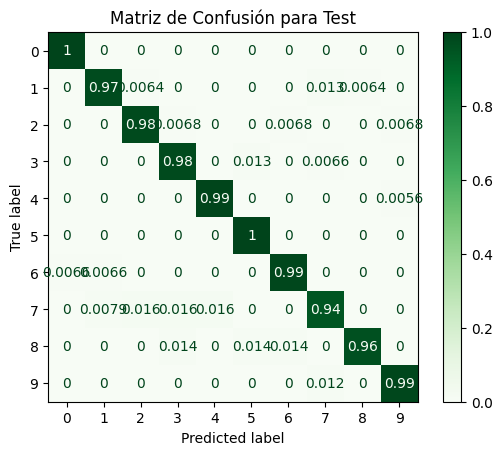

In [11]:
# Matriz de confusión usando el modelo
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay


ConfusionMatrixDisplay.from_estimator(clf,hog_descriptors_test, labels_test, normalize='true', cmap='Greens')
plt.title("Matriz de Confusión para Test")
plt.show()